In [1]:
from keras import backend as K
from keras.datasets import mnist
import keras

from sklearn.metrics import accuracy_score
from scipy.stats import norm
from matplotlib import pyplot as plt
import numpy as np

from math import sqrt
import random

from gaussiannets import ProbabilisticCNN
from datasets import nmnist

def print_digit(digit_data, digit, cnn_class_prob, gpc_class_prob_distr, gcnn_class_prob_distr):
    gpc_class_prob_median, gpc_class_prob_std = gpc_class_prob_distr
    gcnn_class_prob_median, gcnn_class_prob_std = gcnn_class_prob_distr
    two_d = (np.reshape(digit_data, (28, 28)) * 255).astype(np.uint8)
    full_figure = plt.figure(figsize=(15, 10))
    full_figure.add_subplot(341)
    plt.title('Digit %d' % digit)
    plt.imshow(two_d, cmap='gray')
    full_figure.add_subplot(342)
    plt.title('CNN')
    plt.bar(range(10), cnn_class_prob)
    plt.xticks(range(10), range(10))
    full_figure.add_subplot(343)
    plt.title('SPGC')
    plt.bar(range(10), gpc_class_prob_median, yerr=gpc_class_prob_std)
    plt.xticks(range(10), range(10))
    full_figure.add_subplot(344)
    plt.title('GaussianCNN')
    plt.bar(range(10), gcnn_class_prob_median, yerr=gcnn_class_prob_std)
    plt.xticks(range(10), range(10))
    plt.show()

def uncertain_predict(class_probs, class_std=None, prob=0.95):
    if class_std is None:
        return np.argmax(class_probs, axis=1)
    else:
        candidates = []
        for prob_vector, std_vector in zip(class_probs, class_std):
            candidate = np.argmax(prob_vector)
            for digit in range(len(prob_vector)):
                if digit != candidate and \
                   norm.sf(0, prob_vector[candidate] - prob_vector[digit], 
                              sqrt(std_vector[candidate]**2 + std_vector[digit]**2)) < prob:
                        candidate = -1
                        break
            candidates.append(candidate)
        return np.array(candidates)
    
    
def nasu(y_true, y_predicted, penalty=1):
    score = 0
    for label_true, label_predicted in zip(y_true, y_predicted):
        if label_predicted == -1:
            pass
        elif label_predicted == label_true:
            score += 1
        else:
            score -= penalty
    return score/len(y_true)

    
save_path = None             #Path to serialize the model. If none it will not serialize it
load_path = "weights.pkl"   #Path to load a serialized model. If none it will retrain from scratch

Using TensorFlow backend.


## MNIST 

We run the Gaussian CNN with the standard MNIST dataset to check how it fares with 

In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print(x_train.reshape(x_train.shape[0], -1).shape)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train_m = keras.utils.to_categorical(y_train, 10)

model = ProbabilisticCNN(input_shape, 10, epochs=9, baseline=True)
if load_path is not None:
    model.load(load_path, x_train, y_train_m)
else:
    model.fit(x_train, y_train_m)

if save_path is not None:
    model.save(save_path)

(60000, 784)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [2]:
gcnn_class_prob_dist = np.array(model.predict(x_test))
cnn_class_prob_raw, gpc_class_prob_dist = model.predict(x_test, raw_predict=True)
gpc_class_prob_dist = np.array(gpc_class_prob_dist)

y_predict_all_gcnn = uncertain_predict(gcnn_class_prob_dist[0])
y_predict_unc_gcnn = uncertain_predict(gcnn_class_prob_dist[0], gcnn_class_prob_dist[1], 1)#
y_predict_all_gpc = uncertain_predict(gpc_class_prob_dist[0])
y_predict_unc_gpc = uncertain_predict(gpc_class_prob_dist[0], gpc_class_prob_dist[1], 1)
y_predict_raw = uncertain_predict(cnn_class_prob_raw)

acc_raw = accuracy_score(y_test, y_predict_raw)
acc_gaussian = accuracy_score(y_test, y_predict_all_gcnn)
acc_gpc = accuracy_score(y_test, y_predict_all_gpc)
print('CNN accuracy: %4f, GaussianCNN accuracy: %4f, GPC accuracy: %4f' % (acc_raw, acc_gaussian, acc_gpc))

score_raw = nasu(y_test, y_predict_raw, 10)
score_gaussian = nasu(y_test, y_predict_unc_gcnn, 10)
score_gpc = nasu(y_test, y_predict_unc_gpc, 10)
for X in [1, 3, 10]:
    score_raw = nasu(y_test, y_predict_raw, X)
    score_gaussian = nasu(y_test, y_predict_unc_gcnn, X)
    score_gpc = nasu(y_test, y_predict_unc_gpc, X)
    print('CNN score: %4f, GuassianCNN score: %4f, GPC score: %4f' % (score_raw, score_gaussian, score_gpc))

NameError: name 'model' is not defined

The difference between the raw CNN and the gaussian CNN is particularly noticable in the more "unclear" images

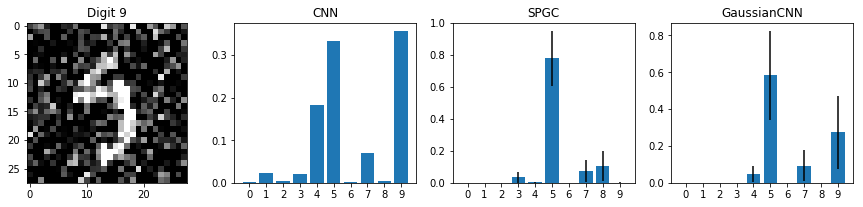

In [69]:
worst_results = np.argsort(np.max(cnn_class_prob_raw, axis=1))[:50]
random_digit = random.choice(worst_results)
print_digit(x_test[random_digit], y_test[random_digit],
            cnn_class_prob_raw[random_digit],
            gpc_class_prob_dist[:, random_digit],
            gcnn_class_prob_dist[:, random_digit])

## N-MNIST

The Neuromorphic-MNIST (N-MNIST) dataset is a spiking version of the original frame-based MNIST dataset. We will now see what role uncernanty plays when the test set is very noisy compared to the training set

In [4]:
# the data, shuffled and split between train and test sets
_, (x_test, y_test_m) = nmnist.load_data()
y_test = np.argmax(y_test_m, axis=1)

if K.image_data_format() == 'channels_first':
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
else:
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    
x_test = x_test.astype('float32')
x_test /= 255

print(x_test.shape[0], 'test samples')

gcnn_class_prob_dist = np.array(model.predict(x_test))
cnn_class_prob_raw, gpc_class_prob_dist = model.predict(x_test, raw_predict=True)
gpc_class_prob_dist = np.array(gpc_class_prob_dist)

y_predict_all_gcnn = uncertain_predict(gcnn_class_prob_dist[0])
y_predict_unc_gcnn = uncertain_predict(gcnn_class_prob_dist[0], gcnn_class_prob_dist[1], 1)#
y_predict_all_gpc = uncertain_predict(gpc_class_prob_dist[0])
y_predict_unc_gpc = uncertain_predict(gpc_class_prob_dist[0], gpc_class_prob_dist[1], 1)
y_predict_raw = uncertain_predict(cnn_class_prob_raw)

acc_raw = accuracy_score(y_test, y_predict_raw)
acc_gaussian = accuracy_score(y_test, y_predict_all_gcnn)
acc_gpc = accuracy_score(y_test, y_predict_all_gpc)
print('CNN accuracy: %4f, GaussianCNN accuracy: %4f, GPC accuracy: %4f' % (acc_raw, acc_gaussian, acc_gpc))

score_raw = nasu(y_test, y_predict_raw, 10)
score_gaussian = nasu(y_test, y_predict_unc_gcnn, 10)
score_gpc = nasu(y_test, y_predict_unc_gpc, 10)
for X in [1, 3, 10]:
    score_raw = nasu(y_test, y_predict_raw, X)
    score_gaussian = nasu(y_test, y_predict_unc_gcnn, X)
    score_gpc = nasu(y_test, y_predict_unc_gpc, X)
    print('CNN score: %4f, GuassianCNN score: %4f, GPC score: %4f' % (score_raw, score_gaussian, score_gpc))

30000 test samples
CNN accuracy: 0.899000, GaussianCNN accuracy: 0.889100, GPC accuracy: 0.706667
CNN score: 0.798000, GuassianCNN score: 0.709567, GPC score: 0.465000
CNN score: 0.596000, GuassianCNN score: 0.673833, GPC score: 0.381333
CNN score: -0.111000, GuassianCNN score: 0.548767, GPC score: 0.088500


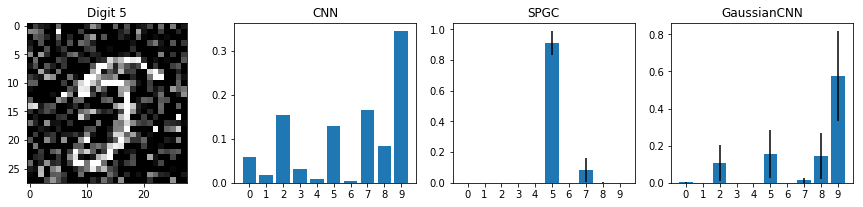

In [70]:
worst_results = np.argsort(np.max(cnn_class_prob_raw, axis=1))[:50]
random_digit = random.choice(worst_results)
print_digit(x_test[random_digit], y_test[random_digit],
            cnn_class_prob_raw[random_digit],
            gpc_class_prob_dist[:, random_digit],
            gcnn_class_prob_dist[:, random_digit])